In [178]:
import datetime
import pandas as pd
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
from firebase_admin import storage
from datetime import date, timedelta
import urllib.request, json 
import time
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import os
import csv


In [17]:
cred = credentials.Certificate("serene-2dfd6-firebase-adminsdk-gfc6o-a312184978.json")
app = firebase_admin.initialize_app(cred ,  {
    'storageBucket': 'serene-2dfd6.appspot.com',
}, name='[DEFAULT]')
db = firestore.client()

In [66]:
# get from app 
duration = 2
userID = "UqTdL3T7MteuQHBe1aNfSE9u0Na2"

## Generate unique ID

In [67]:
# generate report unique ID
today = datetime.datetime.now()
timestamp = today.strftime("%Y-%m-%d %H:%M:%S")
reportId = userID +" "+ timestamp
reportId = reportId.replace(" ","_")

In [62]:
# write to a collection 
doc_ref = db.collection(u'LastGeneratePatientReport').document('tt')
doc_ref.set({
    u'name':'raghad from python',
    u'age':'21'
})

update_time {
  seconds: 1584941272
  nanos: 603258000
}

In [63]:
# store to firebase storage 
bucket = storage.bucket(app=app)
imagePath = "image.png"
imageBlob = bucket.blob("7KXzpejWaRgyuZG9zcKttgaKd002/DoctorReport/python_img")
imageBlob.upload_from_filename(imagePath)

## get list of included dates  

In [68]:
#get a a list of date between start and end date 
dates =[]
for x in range(0 ,duration):
    start_date = (date.today()-timedelta(days=duration-x)).isoformat()
    dates.append(start_date)

## Generate a compelete DF

In [221]:
df= pd.DataFrame()
# loop through the storage and get the data
sleep =[]
for x in range(0 ,len(dates)):
    #Sleep
    blob = bucket.blob(userID+"/fitbitData/"+dates[x]+"/"+dates[x]+"-sleep.json")
    # download the file 
    u = blob.generate_signed_url(datetime.timedelta(seconds=300), method='GET')
    with urllib.request.urlopen(u) as url:
        data = json.loads(url.read().decode())
        sleepMinutes = data['summary']["totalMinutesAsleep"]
        
    #Activity (Steps)
    blob = bucket.blob(userID+"/fitbitData/"+dates[x]+"/"+dates[x]+"-activity.json")
    # download the file 
    u = blob.generate_signed_url(datetime.timedelta(seconds=300), method='GET')
    with urllib.request.urlopen(u) as url:
        data = json.loads(url.read().decode())
        steps = data['summary']["steps"]
    
    #heartrate
    blob = bucket.blob(userID+"/fitbitData/"+dates[x]+"/"+dates[x]+"-heartrate.json")
    u = blob.generate_signed_url(datetime.timedelta(seconds=300), method='GET')
    with urllib.request.urlopen(u) as url:
        data = json.loads(url.read().decode())
        df_heartrate = pd.DataFrame(data['activities-heart-intraday']['dataset'])
    df_heartrate.time.apply(str)
    df_heartrate['time'] = pd.to_datetime(df_heartrate['time'])
    df_heartrate['hour'] = df_heartrate['time'].apply(lambda time: time.strftime('%H'))
    df_heartrate.drop(['time'],axis=1, inplace = True)
    heart_rate = df_heartrate.groupby(["hour"], as_index=False).mean()
    heart_rate['sleep'] = sleepMinutes
    heart_rate['steps'] = steps
    heart_rate['date'] = dates[x]
    heart_rate = heart_rate.astype({"hour": int})  
    
    
    # append dataframe
    df = df.append(heart_rate, ignore_index = True)


In [222]:
df.head(5)

,hour,value,sleep,steps,date
0,0,89.237288,591,2964,2020-03-27
1,1,84.833333,591,2964,2020-03-27
2,2,87.016949,591,2964,2020-03-27
3,3,84.350000,591,2964,2020-03-27
4,4,76.750000,591,2964,2020-03-27


In [223]:
# get location from database
loc_df = pd.DataFrame()
locations = db.collection(u'PatientLocations').where(u'patientID', u'==', userID ).stream()

for location in locations:
    loc = location.to_dict()
    loc_df = loc_df.append(pd.DataFrame(loc,index=[0]),ignore_index=True)
       


        


In [224]:
loc_df.drop(['anxietyLevel', 'lat','lng','lon', 'patientID'  ], axis=1, inplace = True)

In [225]:
loc_df.tail(5)

,name,time
91,Al Aqiq,2020-03-28 23:08:37.041000+00:00
92,Al Aqiq,2020-03-28 02:26:10+00:00
93,King Saud University,2020-02-27 02:05:05+00:00
94,Al Malqa,2020-03-01 01:15:00+00:00
95,As Suwaidi,2020-03-24 11:14:13+00:00


In [226]:
loc_df['date'] = pd.to_datetime(loc_df['time'], format='%Y:%M:%D').dt.date
loc_df['hour'] = pd.to_datetime(loc_df['time'], format='%H').dt.time 
loc_df.drop(['time'], axis=1, inplace = True)

In [227]:
loc_df.tail(5)

,name,date,hour
91,Al Aqiq,2020-03-28,23:08:37.041000
92,Al Aqiq,2020-03-28,02:26:10
93,King Saud University,2020-02-27,02:05:05
94,Al Malqa,2020-03-01,01:15:00
95,As Suwaidi,2020-03-24,11:14:13


In [228]:
loc_df['hour'] = loc_df['hour'].apply(lambda time: time.strftime('%H'))


In [229]:
loc_df

,name,date,hour
0,Al Aqiq,2020-03-28,19
1,Al Aqiq,2020-03-29,19
2,Al Aqiq,2020-03-29,02
3,Al Aqiq,2020-03-28,20
4,Al Aqiq,2020-03-29,12
...,...,...,...
91,Al Aqiq,2020-03-28,23
92,Al Aqiq,2020-03-28,02
93,King Saud University,2020-02-27,02
94,Al Malqa,2020-03-01,01


In [242]:
#merge dataframe

 #dfinal = pd.merge(left=df, 
                  # right = loc_df,
                  # left_on=['hour','date'],
                   #right_on=['hour','date'])




ValueError: You are trying to merge on int32 and object columns. If you wish to proceed you should use pd.concat

In [237]:
#dfinal.to_csv('full.csv')

In [ ]:
#test model 


# Plot

## HR

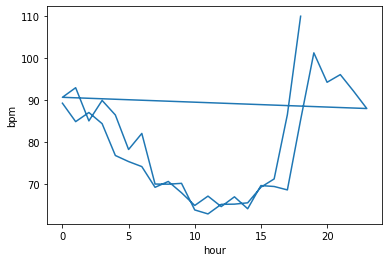

<Figure size 432x288 with 0 Axes>

In [243]:
# plot HR
fig1 = plt.gcf()
plt.plot(df['hour'], df['value'])
plt.xlabel('hour')
plt.ylabel('bpm')
plt.show()
plt.draw()
fig1.savefig('hr.png', dpi=100)
# store HR to firebase
imagePath = "hr.png"
imageBlob = bucket.blob(userID+"/DoctorReport/heartrate")
imageBlob.upload_from_filename(imagePath)
os.remove("hr.png")

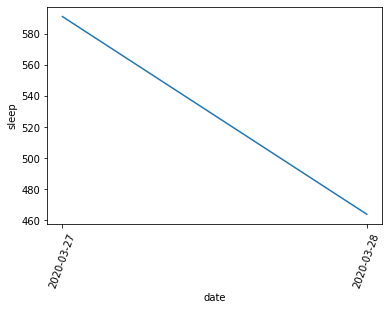

<Figure size 432x288 with 0 Axes>

In [244]:
# plot Sleep
# max plot a 15 date only 
fig1 = plt.gcf()
plt.plot(df['date'], df['sleep'])
plt.xlabel('date')
plt.ylabel('sleep')
plt.tick_params(axis='x', rotation=70)
plt.show()
plt.draw()
fig1.savefig('sleep.png', dpi=100)
# store HR to firebase
imagePath = "sleep.png"
imageBlob = bucket.blob(userID+"/DoctorReport/sleep")
imageBlob.upload_from_filename(imagePath)
#os.remove("sleep.png")